In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint

### Analyzing all CoT for Bongard-Hoi with high image detail

In [2]:
all_cotN = [
    'chain_of_thought0',
    'chain_of_thought1',
    'chain_of_thought2',
    'chain_of_thought3',
    'chain_of_thought0_swap'
]
data = pd.DataFrame()

for cotN in all_cotN:
    test_conditions = [
        'test_seen_obj_seen_act',
        'test_seen_obj_unseen_act',
        'test_unseen_obj_seen_act',
        'test_unseen_obj_unseen_act'
    ]

    for test_condition in test_conditions:

        if cotN != 'chain_of_thought0_swap':
            gpt4o_path = f'../fewshot_gpt-4o/results/{cotN}/{test_condition}_fewshot_results.csv'
            data_test_condition_gpt4o = pd.read_csv(gpt4o_path)
            data_test_condition_gpt4o['cotN'] = cotN
            data_test_condition_gpt4o['agent'] = 'gpt-4o'

        gpt4vi_path = f'../fewshot_gpt-4-vision-preview/results/{cotN}/{test_condition}_fewshot_results.csv'
        data_test_condition_gpt4vis = pd.read_csv(gpt4vi_path)
        data_test_condition_gpt4vis['cotN'] = cotN
        data_test_condition_gpt4vis['agent'] = 'gpt-4-vision-preview'

        data = pd.concat([data, data_test_condition_gpt4o, data_test_condition_gpt4vis])


In [3]:
hoitrans = {
    # 'test_seen_obj_seen_act': 59.5,
    # 'test_seen_obj_unseen_act': 63.1,
    # 'test_unseen_obj_seen_act': 64.38,
    # 'test_unseen_obj_unseen_act': 62.87,
    'average_accuracy': 62.46
}
hoitrans = pd.DataFrame.from_dict(hoitrans, orient='index')
hoitrans.columns = ['accuracy']
hoitrans = hoitrans.reset_index().rename(columns={'index': 'test_condition'})
hoitrans['agent'] = 'HOITrans'
hoitrans['cotN'] = 'chain_of_thought0'

human = {
    # 'test_seen_obj_seen_act': 87.21,
    # 'test_seen_obj_unseen_act': 93.61,
    # 'test_unseen_obj_seen_act': 90.01,
    # 'test_unseen_obj_unseen_act': 94.85,
    'average_accuracy': 91.42
}
human = pd.DataFrame.from_dict(human, orient='index')
human.columns = ['accuracy']
human = human.reset_index().rename(columns={'index': 'test_condition'})
human['agent'] = 'Humans'
human['cotN'] = 'chain_of_thought0'

In [4]:
# Define all data
all_data = pd.concat([hoitrans, human])
all_data['accuracy'] = all_data['accuracy'] / 100

# Extract important things from data for each chain of thought condition
for model in ['gpt-4o', 'gpt-4-vision-preview']:
    for cotN in all_cotN:

        # Get model's performance
        model_cot = data[(data.cotN == cotN) & (data.agent == model)]

        def only_ten_per_concept(rows_concept):
            if len(rows_concept) >= 10:
                rows_concept = rows_concept.reset_index(drop=True).loc[:9]
            return rows_concept
        model_cot = model_cot.groupby(['concept']).apply(only_ten_per_concept)
        model_cot = model_cot[['test_condition', 'accuracy','concept','agent','cotN']]
        all_data = pd.concat([all_data, model_cot], ignore_index=True)

        print('Model:', model)
        print('Condition:', cotN)
        print('Shape:', model_cot.shape)
        print('Number of Unique Concepts:', len(model_cot.concept.unique()))
        print('Unique counts per concept:', model_cot.concept.value_counts().unique())
        print('Overall Accuracy:', model_cot.accuracy.mean())
        print()

Model: gpt-4o
Condition: chain_of_thought0
Shape: (1194, 5)
Number of Unique Concepts: 166
Unique counts per concept: [10  8  6  4  2]
Overall Accuracy: 0.7572093023255814

Model: gpt-4o
Condition: chain_of_thought1
Shape: (1194, 5)
Number of Unique Concepts: 166
Unique counts per concept: [10  8  6  4  2]
Overall Accuracy: 0.7250698974836906

Model: gpt-4o
Condition: chain_of_thought2
Shape: (1194, 5)
Number of Unique Concepts: 166
Unique counts per concept: [10  8  6  4  2]
Overall Accuracy: 0.7121634168987929

Model: gpt-4o
Condition: chain_of_thought3
Shape: (1208, 5)
Number of Unique Concepts: 166
Unique counts per concept: [10  8  6  4  2]
Overall Accuracy: 0.6485740570377185

Model: gpt-4o
Condition: chain_of_thought0_swap
Shape: (0, 5)
Number of Unique Concepts: 0
Unique counts per concept: []
Overall Accuracy: nan

Model: gpt-4-vision-preview
Condition: chain_of_thought0
Shape: (1194, 5)
Number of Unique Concepts: 166
Unique counts per concept: [10  8  6  4  2]
Overall Accurac

['gpt-4o' 'gpt-4-vision-preview']


/tmp/ipykernel_1492382/101202972.py:17: UserWarning: The palette list has more values (9) than needed (4), which may not be intended.
  sns.barplot(


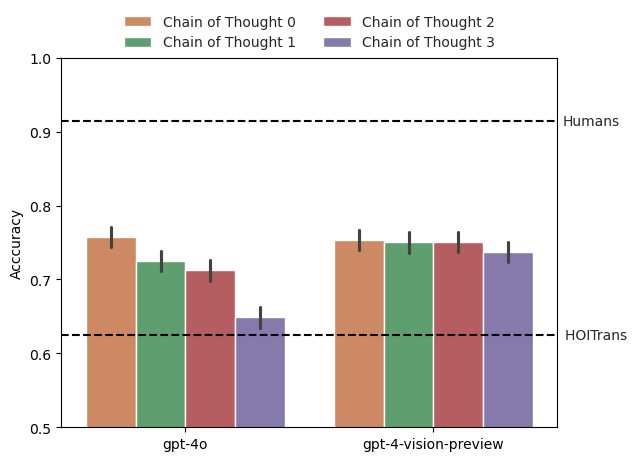

In [5]:
# Remove humans and hoitrans, for plotting
no_human_hoitrans = all_data[(all_data.agent != 'Humans') & (all_data.agent != 'HOITrans')]
no_human_hoitrans = no_human_hoitrans[no_human_hoitrans.cotN != 'chain_of_thought0_swap']
print(no_human_hoitrans.agent.unique())


def standard_error_proportion(group):
    count = group.sum()
    nobs = len(group)
    p = count / nobs
    sep = np.sqrt(p * (1 - p) / nobs)
    return p - sep, p + sep

fig, ax = plt.subplots(figsize = (6.4, 4.8))
sns.set_style('ticks')

sns.barplot(
    data = no_human_hoitrans,
    x = 'agent',
    y = 'accuracy',
    hue = 'cotN',
    errorbar = lambda x: standard_error_proportion(x),
    palette = sns.color_palette('deep')[1:]
).set(
    ylabel = 'Acccuracy',
    xlabel = '',
    ylim = (0.5,1)
)
# sns.despine()

ax.axhline(y = .9142, label = 'Humans', linestyle='--', c='black')
ax.axhline(y = .6246, label = 'HOITrans', linestyle='--', c='black')

ax.text(1.75, .9142-0.01, 'Humans',  ha='right', va='bottom')
ax.text(1.8, .6246-0.01, 'HOITrans ', ha='right', va='bottom')

handles, labels = ax.get_legend_handles_labels()
cotlist = ['Chain of Thought 0', 'Chain of Thought 1', 'Chain of Thought 2', 'Chain of Thought 3']
# plt.legend(labels = cotlist, handles = handles, ncols=2, loc='upper left').get_frame().set_linewidth(0.0)
# legend = plt.legend(labels=cotlist, handles=handles, ncols=2, loc='upper center', bbox_to_anchor=(-0.3, 1), frameon=False)
legend = plt.legend(labels=cotlist, handles=handles, ncols=2, loc='upper center', bbox_to_anchor=(0.5, 1.15), frameon=False)


/tmp/ipykernel_30518/550989419.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_cot['agent'] = pd.Categorical(no_cot['agent'], categories=custom_order, ordered=True)
/tmp/ipykernel_30518/550989419.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_30518/550989419.py:36: UserWarning: 
The palette list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
/tmp/ipykernel_30518/550989419.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
 

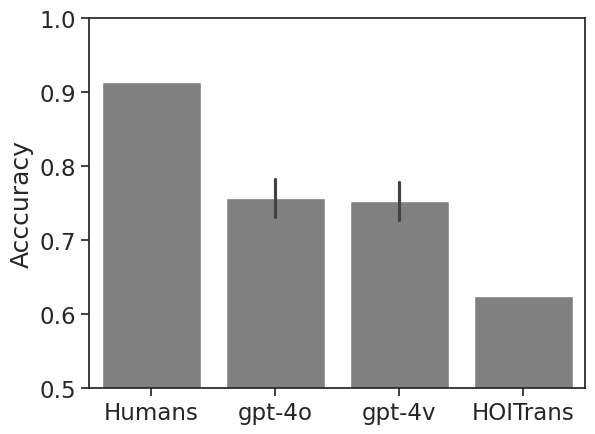

In [36]:
# For just chain of thought 0

# Remove all other 
no_cot = all_data[(all_data.cotN == 'chain_of_thought0') | (all_data.agent.isin(['Humans', 'HOITrans']))]
custom_order = [
    'Humans',
    'gpt-4o',
    'gpt-4-vision-preview',
    'HOITrans',
]
no_cot['agent'] = pd.Categorical(no_cot['agent'], categories=custom_order, ordered=True)

# Unique color for each bar
custom_palette = {
    'HOITrans': sns.color_palette('deep')[3],
    'gpt-4o': sns.color_palette('deep')[1],
    'gpt-4-vision-preview': sns.color_palette('deep')[2],
    'Humans': sns.color_palette('deep')[0]
}

# def standard_error_proportion(group):
#     count = group.sum()
#     nobs = len(group)
#     p = count / nobs
#     sep = np.sqrt(p * (1 - p) / nobs)
#     return p - sep, p + sep
def proportion_confint_custom(x):
    count = sum(x)  # Number of successes (or positive outcomes)
    nobs = len(x)   # Number of observations (total trials)
    lower, upper = proportion_confint(count, nobs, alpha=0.05, method='normal')
    return (lower, upper)

sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.5)
fig, ax = plt.subplots(figsize = (6.4, 4.8))
sns.barplot(
    data = no_cot,
    x = 'agent',
    y = 'accuracy',
    errorbar = lambda x: proportion_confint_custom(x),
    palette = sns.color_palette('gray', n_colors=1)
).set(
    ylabel = 'Acccuracy',
    xlabel = '',
    ylim = (0.5,1),
    xticklabels = ['Humans', 'gpt-4o', 'gpt-4v', 'HOITrans']
)
plt.legend().remove()


In [17]:
all_data[all_data.agent == 'gpt-4o'].

,test_condition,accuracy,agent,cotN,concept
2,test_unseen_obj_unseen_act,1.0,gpt-4o,chain_of_thought0,adjust_or_tie++tie
3,test_unseen_obj_unseen_act,0.0,gpt-4o,chain_of_thought0,adjust_or_tie++tie
4,test_unseen_obj_unseen_act,1.0,gpt-4o,chain_of_thought0,adjust_or_tie++tie
5,test_unseen_obj_unseen_act,1.0,gpt-4o,chain_of_thought0,adjust_or_tie++tie
6,test_unseen_obj_unseen_act,1.0,gpt-4o,chain_of_thought0,adjust_or_tie++tie
...,...,...,...,...,...
4787,test_seen_obj_unseen_act,NaN,gpt-4o,chain_of_thought3,wield++knife
4788,test_seen_obj_unseen_act,NaN,gpt-4o,chain_of_thought3,wield++knife
4789,test_seen_obj_unseen_act,NaN,gpt-4o,chain_of_thought3,wield++knife
4790,test_seen_obj_unseen_act,NaN,gpt-4o,chain_of_thought3,wield++knife


In [13]:
no_cot[no_cot.agent == 'gpt-4-vision-preview'].accuracy.mean()

0.7532588454376163

/tmp/ipykernel_30518/731350588.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_30518/731350588.py:24: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(
/tmp/ipykernel_30518/731350588.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ).set(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


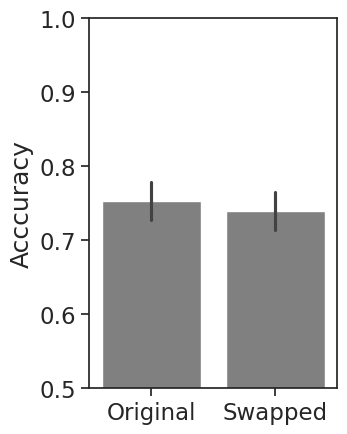

In [37]:
# Compare cot0 swap for gpt-4-vision-preview
cot0swap = all_data[(all_data.agent == 'gpt-4-vision-preview') & (all_data.cotN.isin(['chain_of_thought0', 'chain_of_thought0_swap']))]

# Unique color for each bar
custom_palette = {
    'chain_of_thought0': sns.color_palette('deep')[2],
    'chain_of_thought0_swap': sns.color_palette('hls')[4]
}

# def standard_error_proportion(group):
#     count = group.sum()
#     nobs = len(group)
#     p = count / nobs
#     sep = np.sqrt(p * (1 - p) / nobs)
#     return p - sep, p + sep
def proportion_confint_custom(x):
    count = sum(x)  # Number of successes (or positive outcomes)
    nobs = len(x)   # Number of observations (total trials)
    lower, upper = proportion_confint(count, nobs, alpha=0.05, method='normal')
    return (lower, upper)

sns.set_context('notebook', font_scale=1.5)
fig, ax = plt.subplots(figsize = (3.2, 4.8))
sns.barplot(
    data = cot0swap,
    x = 'cotN',
    y = 'accuracy',
    errorbar = lambda x: proportion_confint_custom(x),
    palette = sns.color_palette('gray', n_colors=1)
).set(
    ylabel = 'Acccuracy',
    xlabel = '',
    ylim = (0.5,1),
    xticklabels = ['Original', 'Swapped']
)
handles, _ = ax.get_legend_handles_labels()
plt.legend(labels = ['Original class labels', 'Swapped labels'], loc='upper left', handles = handles).get_frame().set_linewidth(0.0)

In [10]:
all_data.to_csv('analysis/bongardhoi_allagents.csv')